In [1]:
import numpy as np
import pandas as pd

from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, column_or_1d
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.base import BaseEstimator
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from tscv import GapKFold

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

Set a benchmark model and test models without seasonal decomposition

In [2]:
filepath = '../../../data/intermediate/experimentation_train_sets/'

filename = 'train_b_1176_m_2_sm_n_t_20200205_152517.csv'

df_features = pd.read_csv(filepath + filename, parse_dates=['timestamp'], index_col=['timestamp'])
df_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8713 entries, 2016-01-01 23:00:00 to 2016-12-31 23:00:00
Data columns (total 7 columns):
day_of_week               8713 non-null int64
day_hour                  8713 non-null int64
dew_temperature_ma_24H    8713 non-null float64
dew_temperature           8713 non-null float64
air_temperature_ma_24H    8713 non-null float64
air_temperature           8713 non-null float64
meter_reading             8713 non-null float64
dtypes: float64(5), int64(2)
memory usage: 544.6 KB


In [3]:
df_features.head()

,day_of_week,day_hour,dew_temperature_ma_24H,dew_temperature,air_temperature_ma_24H,air_temperature,meter_reading
timestamp,,,,,,,
2016-01-01 23:00:00,4,23,-10.283333,-8.3,-6.229167,-2.8,0.0
2016-01-02 00:00:00,5,0,-10.120833,-8.3,-6.020833,-3.3,0.0
2016-01-02 01:00:00,5,1,-9.979167,-8.3,-5.837500,-3.9,0.0
2016-01-02 02:00:00,5,2,-9.887500,-8.9,-5.720833,-5.0,0.0
2016-01-02 03:00:00,5,3,-9.816667,-9.4,-5.629167,-5.6,0.0


In [4]:
target_variables = set(['meter_reading'])
features_variables = set(df_features.columns.to_list())-target_variables
time_variables = set(['day_hour', 'day_of_week'])
meteorological_variables = features_variables - time_variables

print(target_variables)
print(features_variables)
print(time_variables)
print(meteorological_variables)

{'meter_reading'}
{'air_temperature', 'air_temperature_ma_24H', 'dew_temperature', 'day_hour', 'dew_temperature_ma_24H', 'day_of_week'}
{'day_hour', 'day_of_week'}
{'air_temperature', 'dew_temperature_ma_24H', 'dew_temperature', 'air_temperature_ma_24H'}


In [5]:
#y_meter_trend = df_features['meter_reading']
#y_meter_seasonal = df_features['meter_reading_seasonal']
#y_meter_deseasoned = df_features['meter_reading_deseasoned']
Ys_meter = df_features[target_variables]

X_meter = df_features.loc[:, features_variables]
#X_meter_with_day_hour = df_features.loc[:, meteorological_variables.union(set(['day_hour']))]
print('X_meter.shape = {}, Ys_meter.shape = {}'.format(X_meter.shape, Ys_meter.shape))

X_meter.shape = (8713, 6), Ys_meter.shape = (8713, 1)


In [6]:
X_meter.columns

Index(['air_temperature', 'air_temperature_ma_24H', 'dew_temperature',
       'day_hour', 'dew_temperature_ma_24H', 'day_of_week'],
      dtype='object')

In [7]:
# GapKFold
# gap ~ two weeks, train = 1 month (12 folds)

gap = 24*7*2
gap_kf = GapKFold(n_splits=12, gap_before=gap, gap_after=gap)

Let's build a mean value estimator.

From https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/_template.py

check_array and check_X_y

https://github.com/scikit-learn/scikit-learn/blob/e5698bde9/sklearn/utils/validation.py#L904

In [8]:
# Actually we don't need that because it already exists in sklearn, under the name 'dummyRegressor'
# https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html

In [12]:
Ys_meter['meter_reading'].mean()

571.4579107655212

In [9]:
cross_val_score(
    estimator=DummyRegressor(strategy="mean"),
    X=X_meter,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-5.312654335287311

In [10]:
cross_val_score(
    estimator=DummyRegressor(strategy="median"),
    X=X_meter,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-5.092180930040629

In [13]:
# Now let's take the mean by hour

In [14]:
class MeanByCatEstimator(BaseEstimator):
    """ A template estimator to be used as a reference implementation.
    For more information regarding how to build your own estimator, read more
    in the :ref:`User Guide <user_guide>`.
    Parameters
    ----------
    demo_param : str, default='demo_param'
        A parameter used for demonstation of how to pass and store paramters.
    """
    def __init__(self, cat_column_idx=0, verbose=False):
        self.verbose = verbose
        self.cat_column_idx= cat_column_idx

    def fit(self, X, y):
        """A reference implementation of a fitting function.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).
        Returns
        -------
        self : object
            Returns self.
        """
        
        X, y = check_X_y(X, y, accept_sparse=True)
        """Input validation for standard estimators.
        Checks X and y for consistent length, enforces X to be 2D and y 1D. By
        default, X is checked to be non-empty and containing only finite values.
        Standard input checks are also applied to y, such as checking that y
        does not have np.nan or np.inf targets. For multi-label y, set
        multi_output=True to allow 2D and sparse y. If the dtype of X is
        object, attempt converting to float, raising on failure.
        """
        
        if(self.cat_column_idx >= X.shape[1]):
             raise ValueError("category column index should be < X.shape[1]")
        
        categories = {}
        self.means = {}
        
        self.mean = y.mean()
        
        for x_bin in np.unique(X[:, self.cat_column_idx]):
            categories[x_bin] = []
            
        if self.verbose:    
            print('categories : {}'.format(categories.keys()))
            
        for k in range(X.shape[0]):
            categories[X[k, self.cat_column_idx]].append(y[k])
        
        for k, v in categories.items():
            self.means[k] = np.array(v).mean()
        
        self.is_fitted_ = True
        # `fit` should always return `self`
        
        if self.verbose:
            for k, v in self.means.items():
                print('({}, {})'.format(k, v))
        
        return self

    
    
    def predict(self, X):
        """ A reference implementation of a predicting function.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns an array of ones.
        """
        
        
        X = check_array(X, accept_sparse=True)
        """Input validation on an array, list, sparse matrix or similar.
        By default, the input is checked to be a non-empty 2D array containing
        only finite values. If the dtype of the array is object, attempt
        converting to float, raising on failure."""
        
        check_is_fitted(self, 'is_fitted_')
        
        predictions = []
        
        for sample_cat in X[:, self.cat_column_idx]:
            cat_mean = self.means.get(sample_cat)
            if(cat_mean == None):
                predictions.append(self.mean)
            else:
                predictions.append(cat_mean)
            
        
        return np.array(predictions)

In [15]:
day_hour_col_idx = X_meter.columns.to_list().index('day_hour')

cross_val_score(
    estimator=MeanByCatEstimator(cat_column_idx=day_hour_col_idx),
    X=X_meter,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-5.302572753015684

In [16]:
class MeanByMultiCatEstimator(BaseEstimator):
    """ A template estimator to be used as a reference implementation.
    For more information regarding how to build your own estimator, read more
    in the :ref:`User Guide <user_guide>`.
    Parameters
    ----------
    demo_param : str, default='demo_param'
        A parameter used for demonstation of how to pass and store paramters.
    """
    def __init__(self, cat_column_indexes=[0], verbose=False):
        self.verbose = verbose
        self.cat_column_indexes = cat_column_indexes

    def fit(self, X, y):
        """A reference implementation of a fitting function.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).
        Returns
        -------
        self : object
            Returns self.
        """
        
        X, y = check_X_y(X, y, accept_sparse=True)
        """Input validation for standard estimators.
        Checks X and y for consistent length, enforces X to be 2D and y 1D. By
        default, X is checked to be non-empty and containing only finite values.
        Standard input checks are also applied to y, such as checking that y
        does not have np.nan or np.inf targets. For multi-label y, set
        multi_output=True to allow 2D and sparse y. If the dtype of X is
        object, attempt converting to float, raising on failure.
        """
        
        
        cat_columns = []
        
        for col_idx in self.cat_column_indexes:
            if(col_idx >= X.shape[1]):
                raise ValueError("category column indexes should be < X.shape[1]")
            cat_columns.append(X[:, col_idx])
            
        cat_tuples = set(zip(*cat_columns))
        
        categories = {}
        self.means = {}
        
        self.mean = y.mean()
        
        for x_bin in cat_tuples:
            categories[x_bin] = []
            
        if self.verbose:    
            print('categories : {}'.format(categories.keys()))
            
        for k in range(X.shape[0]):
            sample_bin = tuple(X[k, self.cat_column_indexes])
            categories[sample_bin].append(y[k])
        
        for k, v in categories.items():
            self.means[k] = np.array(v).mean()
        
        self.is_fitted_ = True
        # `fit` should always return `self`
        
        if self.verbose:
            for k, v in self.means.items():
                print('({}, {})'.format(k, v))
        
        return self

    
    
    def predict(self, X):
        """ A reference implementation of a predicting function.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns an array of ones.
        """
        
        
        X = check_array(X, accept_sparse=True)
        """Input validation on an array, list, sparse matrix or similar.
        By default, the input is checked to be a non-empty 2D array containing
        only finite values. If the dtype of the array is object, attempt
        converting to float, raising on failure."""
        
        check_is_fitted(self, 'is_fitted_')
        
        predictions = []
        
        
        cat_columns=[]
        for col in self.cat_column_indexes:
            cat_columns.append(X[:, col])
            
        cat_tuples = list(zip(*cat_columns))
        
        
        
        for sample_cat in cat_tuples:
            cat_mean = self.means.get(sample_cat)
            if(cat_mean == None):
                predictions.append(self.mean)
            else:
                predictions.append(cat_mean)
            
        
        
        return np.array(predictions)

In [17]:
day_hour_col_idx = X_meter.columns.to_list().index('day_hour')
day_of_week_col_idx = X_meter.columns.to_list().index('day_of_week')
time_col_indexes = [day_hour_col_idx, day_of_week_col_idx]

In [18]:
cross_val_score(
    estimator=MeanByMultiCatEstimator(time_col_indexes),
    X=X_meter,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-5.290310152716245

Build a benchmark wich computes means but switch regime when temperature is higher.

In [22]:
min_T_limit = np.floor(X_meter['air_temperature_ma_24H'].min())
max_T_limit = np.ceil(X_meter['air_temperature_ma_24H'].max())

bins_T = [min_T_limit, 0, 10, 20, max_T_limit]
bins_T_labels = [0, 1, 2, 3]

X_meter_w_temperature_bins = X_meter.copy()
X_meter_w_temperature_bins['temperature_bin'] = pd.cut(
    X_meter['air_temperature_ma_24H'], 
    bins=bins_T, 
    labels=bins_T_labels
)

In [23]:
day_hour_col_idx = X_meter_w_temperature_bins.columns.to_list().index('day_hour')
temperature_bin_col_idx = X_meter_w_temperature_bins.columns.to_list().index('temperature_bin')
cat_col_indexes = [day_hour_col_idx, temperature_bin_col_idx]

In [24]:
cross_val_score(
    estimator=MeanByMultiCatEstimator(cat_col_indexes),
    X=X_meter_w_temperature_bins,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-5.995640660267436

In [25]:
day_hour_col_idx = X_meter_w_temperature_bins.columns.to_list().index('day_hour')
day_of_week_col_idx = X_meter.columns.to_list().index('day_of_week')
temperature_bin_col_idx = X_meter_w_temperature_bins.columns.to_list().index('temperature_bin')
cat_col_indexes = [day_hour_col_idx, day_of_week_col_idx, temperature_bin_col_idx]

In [26]:
cross_val_score(
    estimator=MeanByMultiCatEstimator(cat_col_indexes),
    X=X_meter_w_temperature_bins,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-6.0156297719271015

Visualize benchmark predictions

In [27]:
benchmark_preds = cross_val_predict(
    estimator=MeanByMultiCatEstimator(cat_col_indexes),
    X=X_meter_w_temperature_bins,
    y=Ys_meter['meter_reading'],
    cv=gap_kf
)

preds_df = pd.DataFrame(index=X_meter.index)
preds_df['target'] = Ys_meter['meter_reading']
preds_df['benchmark_preds'] = benchmark_preds

preds_df_melt = pd.melt(
    preds_df.reset_index(inplace=False),
    id_vars='timestamp', 
    var_name='component', 
    value_name = 'reading'
)

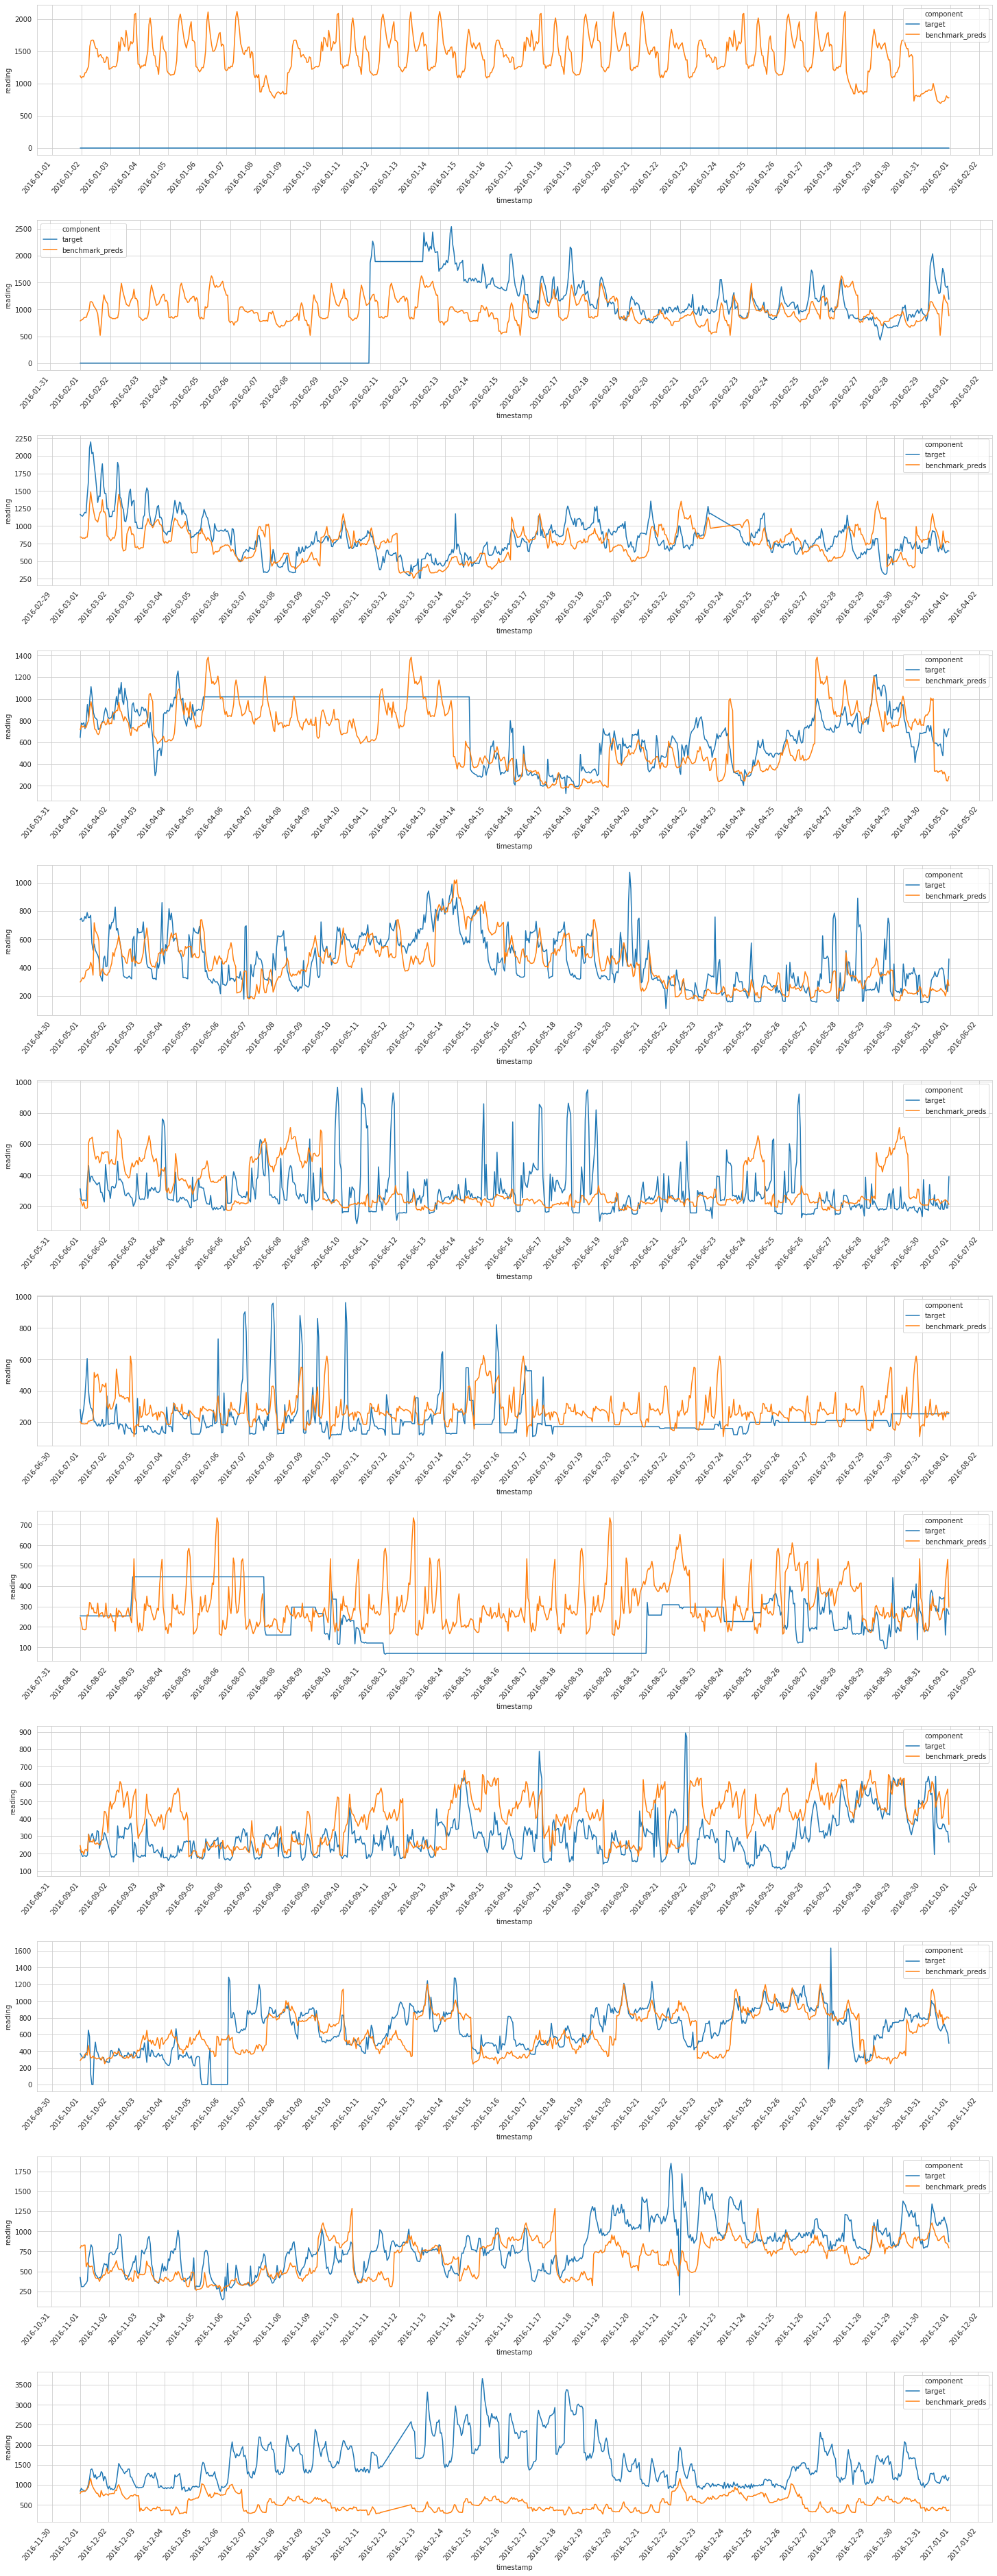

In [28]:
# Plot month by month

date_range = pd.date_range(start=X_meter.index.min()-pd.Timedelta('1 days'), 
                           end=X_meter.index.max(), freq='1M')

fig = plt.figure(figsize=(20, 4*date_range.shape[0]))

restrict_df_to_dates = lambda df, d1, d2 : df[(df['timestamp'] > d1) & (df['timestamp'] <= d2)]


with sns.axes_style("whitegrid"):
    for i in range(date_range.shape[0]-1) :
        plt.subplot(12,1,i+1)
        start_date = date_range[i]
        end_date = date_range[i+1]
        data = restrict_df_to_dates(preds_df_melt, start_date, end_date)
        ax = sns.lineplot(x="timestamp", y="reading", hue="component", data=data)
        ax.xaxis.set_major_locator(mdates.DayLocator())
        plt.xticks(rotation=50, horizontalalignment='right')
plt.tight_layout(pad=0., w_pad=0., h_pad=2.)    

<b>Random forest model</b>

In [29]:
trendRFR = RandomForestRegressor()

pipe = make_pipeline(trendRFR)
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'randomforestregressor', 'randomforestregressor__bootstrap', 'randomforestregressor__criterion', 'randomforestregressor__max_depth', 'randomforestregressor__max_features', 'randomforestregressor__max_leaf_nodes', 'randomforestregressor__min_impurity_decrease', 'randomforestregressor__min_impurity_split', 'randomforestregressor__min_samples_leaf', 'randomforestregressor__min_samples_split', 'randomforestregressor__min_weight_fraction_leaf', 'randomforestregressor__n_estimators', 'randomforestregressor__n_jobs', 'randomforestregressor__oob_score', 'randomforestregressor__random_state', 'randomforestregressor__verbose', 'randomforestregressor__warm_start'])

In [30]:
rfr_grid_params = {
    'randomforestregressor__n_estimators' : [50, 100],
    'randomforestregressor__max_features' : ['auto']
}

rfr_CV = GridSearchCV(
    estimator=pipe, 
    param_grid=rfr_grid_params,
    scoring='neg_mean_squared_log_error',
    cv=gap_kf
)

rfr_CV.fit(X_meter, Ys_meter['meter_reading'])

/home/edouard/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=GapKFold(gap_after=336, gap_before=336, n_splits=12),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('randomforestregressor',
                                        RandomForestRegressor(bootstrap=True,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                              min_samples...
                                      

In [31]:
print('best_params : {}'.format(rfr_CV.best_params_))
print('best_score : {}'.format(rfr_CV.best_score_))

best_params : {'randomforestregressor__max_features': 'auto', 'randomforestregressor__n_estimators': 100}
best_score : -6.795743180174575


In [32]:
cross_val_score(
    estimator=RandomForestRegressor(n_estimators=50, max_features='auto'),
    X=X_meter,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-6.8007616836294735

In [112]:
rfr_estimator=RandomForestRegressor(n_estimators=50, max_features='auto')
rfr_estimator.fit(X=X_meter, y=Ys_meter['meter_reading'])
rfr_estimator.feature_importances_.tolist()

[0.026827097736768887,
 0.3294285435613704,
 0.04919103903397515,
 0.06620362856226614,
 0.03704142571961037,
 0.4913082653860091]

In [123]:
named_feature_importance = zip(X_meter.columns.to_list(), rfr_estimator.feature_importances_.tolist())

feature_importance_df = pd.DataFrame(named_feature_importance, columns=['feature', 'importance_score'])
feature_importance_df.set_index('feature', inplace=True)
feature_importance_df.sort_values(by='importance_score', ascending=False, inplace=True)
feature_importance_df

,importance_score
feature,
air_temperature_ma_24H,0.491308
day_hour,0.329429
dew_temperature_ma_24H,0.066204
day_of_week,0.049191
air_temperature,0.037041
dew_temperature,0.026827


Seems like values that are too high correspond to dates where precip_depth is non-null.<br>
This would be logical as we need less refreshing when it rains.<br>
We'll try to add the feature precip depth in another model.<br>
Let's do more fine tuning to this model, and keep it as a benchmark.<br>

In [108]:
X_meter.head()

,dew_temperature,day_hour,day_of_week,dew_temperature_ma_24H,air_temperature,air_temperature_ma_24H
timestamp,,,,,,
2016-01-01 23:00:00,-8.3,23,4,-10.283333,-2.8,-6.229167
2016-01-02 00:00:00,-8.3,0,5,-10.120833,-3.3,-6.020833
2016-01-02 01:00:00,-8.3,1,5,-9.979167,-3.9,-5.837500
2016-01-02 02:00:00,-8.9,2,5,-9.887500,-5.0,-5.720833
2016-01-02 03:00:00,-9.4,3,5,-9.816667,-5.6,-5.629167


In [33]:
bench_rfr = RandomForestRegressor()

pipe = make_pipeline(bench_rfr)

rfr_grid_params = {
    'randomforestregressor__n_estimators' : [10, 25, 50, 75, 100, 125, 150, 200],
    'randomforestregressor__max_features' : ['auto', 'sqrt'],
    'randomforestregressor__max_depth' : [4, 6, 8, 10, 12, 20, 40]
}

rfr_CV = GridSearchCV(
    estimator=pipe, 
    param_grid=rfr_grid_params,
    scoring='neg_mean_squared_log_error',
    cv=gap_kf
)

rfr_CV.fit(X_meter, Ys_meter['meter_reading'])

print('best_params : {}'.format(rfr_CV.best_params_))
print('best_score : {}'.format(rfr_CV.best_score_))

/home/edouard/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best_params : {'randomforestregressor__max_depth': 4, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__n_estimators': 125}
best_score : -6.039649155280455


In [35]:
benchmark_preds = cross_val_predict(
    estimator=RandomForestRegressor(n_estimators=125, max_depth=4, max_features='sqrt'),
    X=X_meter,
    y=Ys_meter['meter_reading'],
    cv=gap_kf
)

preds_df = pd.DataFrame(index=X_meter.index)
preds_df['target'] = Ys_meter['meter_reading']
preds_df['benchmark_preds'] = benchmark_preds

preds_df_melt = pd.melt(
    preds_df.reset_index(inplace=False),
    id_vars='timestamp', 
    var_name='component', 
    value_name = 'reading'
)

preds_df_melt.head()

,timestamp,component,reading
0,2016-01-01 23:00:00,target,0.0
1,2016-01-02 00:00:00,target,0.0
2,2016-01-02 01:00:00,target,0.0
3,2016-01-02 02:00:00,target,0.0
4,2016-01-02 03:00:00,target,0.0


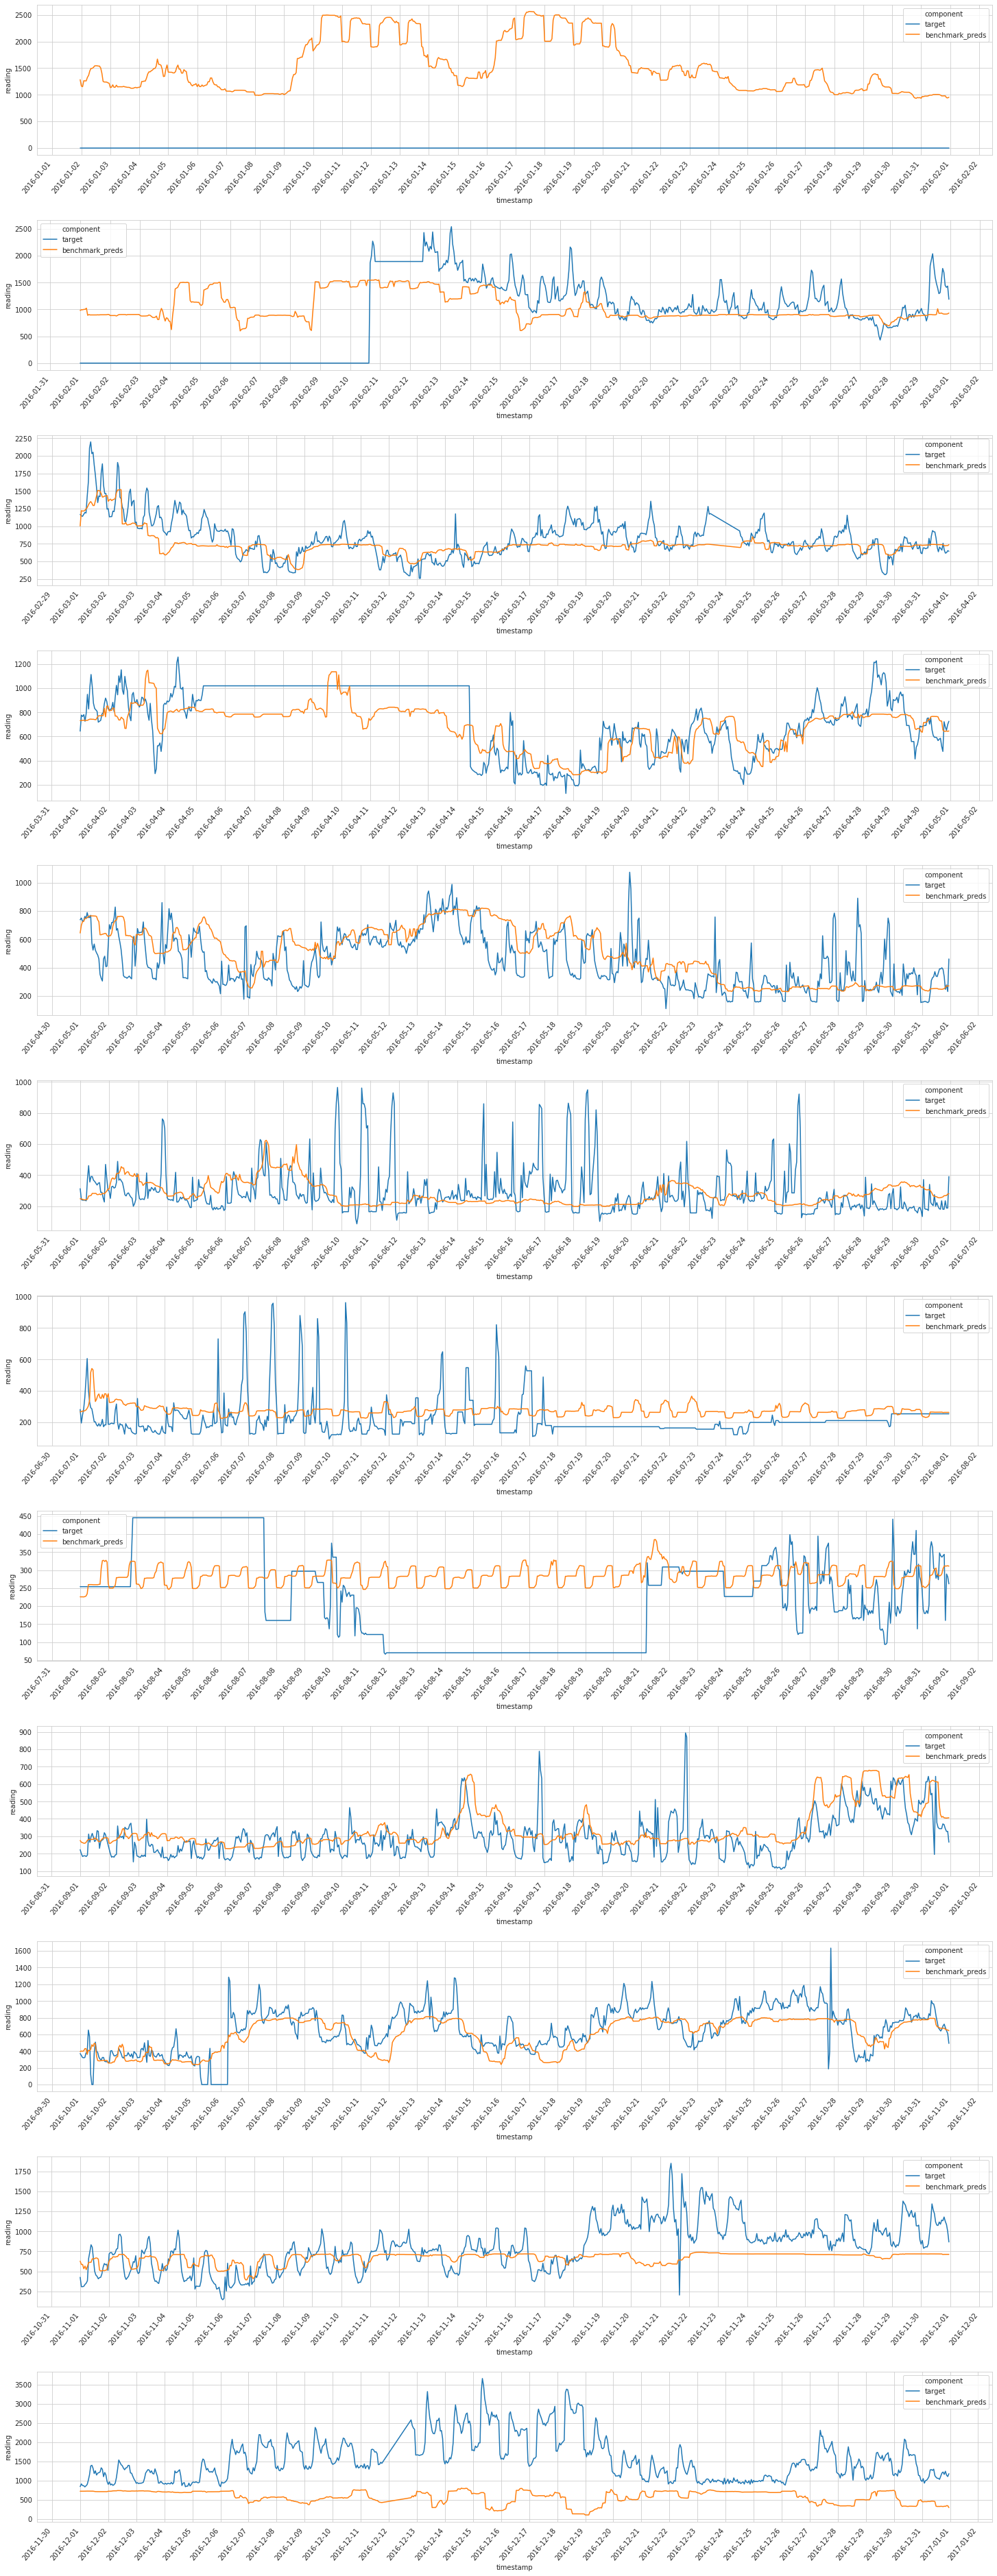

In [36]:
# Plot month by month

date_range = pd.date_range(start=X_meter.index.min()-pd.Timedelta('1 days'), 
                           end=X_meter.index.max(), freq='1M')

fig = plt.figure(figsize=(20, 4*date_range.shape[0]))

restrict_df_to_dates = lambda df, d1, d2 : df[(df['timestamp'] > d1) & (df['timestamp'] <= d2)]


with sns.axes_style("whitegrid"):
    for i in range(date_range.shape[0]-1) :
        plt.subplot(12,1,i+1)
        start_date = date_range[i]
        end_date = date_range[i+1]
        data = restrict_df_to_dates(preds_df_melt, start_date, end_date)
        ax = sns.lineplot(x="timestamp", y="reading", hue="component", data=data)
        ax.xaxis.set_major_locator(mdates.DayLocator())
        plt.xticks(rotation=50, horizontalalignment='right')
plt.tight_layout(pad=0., w_pad=0., h_pad=2.)    